In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import json
import soundfile as sf
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

# === CONFIGURATION ===
RAW_DATA_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Abuzz"
OUTPUT_AUDIO_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_audio_balanced_v2"
OUTPUT_LABEL_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_label_balanced_v2"
TARGET_SR = 16000
MAX_DURATION = 5.0
MAX_LEN = int(MAX_DURATION * TARGET_SR)
MIN_MOSQUITOES = 3
MAX_MOSQUITOES = 7
CHUNK_MIN = 0.3
CHUNK_MAX = 0.6
SNR_RANGE = (30, 50)
MAX_SPECIES_PER_SAMPLE = 3
MIN_SAMPLES_PER_SPECIES = 100

# === AUDIO UTILS ===
def load_random_chunk(filepath, sr=TARGET_SR, min_len=CHUNK_MIN, max_len=CHUNK_MAX):
    y, file_sr = sf.read(filepath)
    if file_sr != sr:
        y = librosa.resample(y.T if y.ndim > 1 else y, orig_sr=file_sr, target_sr=sr)
    if y.ndim == 2:
        y = np.mean(y, axis=1)
    y = y / (np.max(np.abs(y)) + 1e-6)
    chunk_samples = int(random.uniform(min_len, max_len) * sr)
    if len(y) < chunk_samples:
        return None
    start = random.randint(0, len(y) - chunk_samples)
    return y[start:start + chunk_samples]

def mix_chunks_separated(chunks):
    mix = np.zeros(MAX_LEN + TARGET_SR * 3)
    current_time = 0
    for chunk in chunks:
        gain_level = random.choices([0.15, 0.5, 0.85], weights=[0.3, 0.4, 0.3], k=1)[0]
        chunk = chunk * random.uniform(gain_level - 0.05, gain_level + 0.05)
        delay = random.uniform(0.3, 1.2)
        offset = int(current_time * TARGET_SR)
        if offset + len(chunk) > len(mix):
            break
        mix[offset:offset + len(chunk)] += chunk
        current_time += delay
    mix = mix[:MAX_LEN]
    return mix / (np.max(np.abs(mix)) + 1e-6)

def add_noise(signal, snr_range=SNR_RANGE):
    snr = random.uniform(*snr_range)
    noise = np.random.normal(0, 1, signal.shape)
    alpha = 10 ** (-snr / 20)
    return (signal + alpha * noise) / (1 + alpha)

# === MAIN FUNCTION ===
def generate_swarm_dataset(num_samples=300):
    os.makedirs(OUTPUT_AUDIO_DIR, exist_ok=True)
    os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

    species_dirs = [os.path.join(RAW_DATA_DIR, d) for d in os.listdir(RAW_DATA_DIR)
                    if os.path.isdir(os.path.join(RAW_DATA_DIR, d))]

    species_to_files = {}
    for folder in species_dirs:
        species = Path(folder).name
        wavs = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".wav")]
        if wavs:
            species_to_files[species] = wavs

    species_list = list(species_to_files.keys())
    if not species_list:
        print("❌ No valid species with .wav files found.")
        return

    species_generated_count = defaultdict(int)
    generated = 0
    attempts = 0
    max_attempts = 5000

    while generated < num_samples and attempts < max_attempts:
        attempts += 1
        k = random.randint(1, min(MAX_SPECIES_PER_SAMPLE, len(species_list)))
        species_sampled = random.sample(species_list, k=k)

        num_mosquitoes = random.randint(MIN_MOSQUITOES, MAX_MOSQUITOES)
        chunks = []
        species_count = {sp: 0 for sp in species_sampled}

        for _ in range(num_mosquitoes):
            sp = random.choice(species_sampled)
            candidates = species_to_files.get(sp, [])
            if not candidates:
                continue
            file = random.choice(candidates)
            chunk = load_random_chunk(file)
            if chunk is None or len(chunk) == 0:
                continue
            chunks.append(chunk)
            species_count[sp] += 1

        if not chunks:
            continue

        present_species = {k: v for k, v in species_count.items() if v > 0}
        if not present_species:
            continue

        if all(species_generated_count[sp] >= MIN_SAMPLES_PER_SPECIES for sp in present_species):
            continue

        waveform = mix_chunks_separated(chunks)
        waveform = add_noise(waveform)

        audio_filename = f"swarm_{generated:04d}.wav"
        label_filename = f"swarm_{generated:04d}.json"

        sf.write(os.path.join(OUTPUT_AUDIO_DIR, audio_filename), waveform, TARGET_SR)
        with open(os.path.join(OUTPUT_LABEL_DIR, label_filename), "w") as f:
            json.dump({
                "filename": audio_filename,
                "num_mosquitoes": sum(present_species.values()),
                "species_count": present_species
            }, f, indent=2)

        for sp in present_species:
            species_generated_count[sp] += 1

        generated += 1

    print(f"✅ Generated {generated} samples.")
    print("Species distribution:")
    for sp in species_list:
        print(f"  - {sp}: {species_generated_count[sp]} samples")

# Run
generate_swarm_dataset(num_samples=600)

✅ Generated 315 samples.
Species distribution:
  - Ae. aegypti: 100 samples
  - Ae. albopictus: 103 samples
  - An. arabiensis: 101 samples
  - An. gambiae: 100 samples
  - C. pipiens: 115 samples
  - C. quinquefasciatus: 103 samples


feature

# Feature Generator

In [ ]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import pywt
import librosa
import librosa.display
from tqdm import tqdm

# === CONFIGURATION ===
AUDIO_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_audio_balanced_v2"
OUTPUT_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/features_balanced_v2"
TARGET_SR = 16000
METHOD = "sfft"  # choose: "cwt" or "sfft"
IMG_SIZE = (224, 224)

# === UTILS ===
def save_melspectrogram(y, sr, out_path):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    db_mel = librosa.power_to_db(mel, ref=np.max)

    fig, ax = plt.subplots()
    librosa.display.specshow(db_mel, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.axis('off')
    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

def save_cwt_image(y, sr, out_path):
    scales = np.arange(1, 128)
    coefficients, _ = pywt.cwt(y, scales, 'morl', sampling_period=1/sr)
    cwt_abs = np.abs(coefficients)

    fig, ax = plt.subplots()
    ax.imshow(cwt_abs, extent=[0, len(y)/sr, 1, 128], cmap='viridis', aspect='auto')
    ax.axis('off')
    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# === MAIN CONVERSION ===
def convert_all_audio():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    audio_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith(".wav")]

    for f in tqdm(audio_files, desc=f"Converting with method: {METHOD.upper()}"):
        path = os.path.join(AUDIO_DIR, f)
        y, sr = sf.read(path)
        if sr != TARGET_SR:
            y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)

        out_name = os.path.splitext(f)[0] + ".png"
        out_path = os.path.join(OUTPUT_DIR, METHOD, out_name)
        os.makedirs(os.path.dirname(out_path), exist_ok=True)

        if METHOD == "cwt":
            save_cwt_image(y, TARGET_SR, out_path)
        elif METHOD == "sfft":
            save_melspectrogram(y, TARGET_SR, out_path)

# 🚀 Run
convert_all_audio()

Converting with method: SFFT: 100%|██████████| 315/315 [00:52<00:00,  6.00it/s]


In [ ]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import pywt
import librosa
import librosa.display
from tqdm import tqdm

# === CONFIGURATION ===
AUDIO_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_audio_balanced"
OUTPUT_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/features_balanced"
TARGET_SR = 16000
METHOD = "cwt"  # choose: "cwt" or "sfft"
IMG_SIZE = (224, 224)

# === UTILS ===
def save_melspectrogram(y, sr, out_path):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    db_mel = librosa.power_to_db(mel, ref=np.max)

    fig, ax = plt.subplots()
    librosa.display.specshow(db_mel, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.axis('off')
    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

def save_cwt_image(y, sr, out_path):
    scales = np.arange(1, 128)
    coefficients, _ = pywt.cwt(y, scales, 'morl', sampling_period=1/sr)
    cwt_abs = np.abs(coefficients)

    fig, ax = plt.subplots()
    ax.imshow(cwt_abs, extent=[0, len(y)/sr, 1, 128], cmap='viridis', aspect='auto')
    ax.axis('off')
    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# === MAIN CONVERSION ===
def convert_all_audio():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    audio_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith(".wav")]

    for f in tqdm(audio_files, desc=f"Converting with method: {METHOD.upper()}"):
        path = os.path.join(AUDIO_DIR, f)
        y, sr = sf.read(path)
        if sr != TARGET_SR:
            y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)

        out_name = os.path.splitext(f)[0] + ".png"
        out_path = os.path.join(OUTPUT_DIR, METHOD, out_name)
        os.makedirs(os.path.dirname(out_path), exist_ok=True)

        if METHOD == "cwt":
            save_cwt_image(y, TARGET_SR, out_path)
        elif METHOD == "sfft":
            save_melspectrogram(y, TARGET_SR, out_path)

# 🚀 Run
convert_all_audio()

Converting with method: CWT:  69%|██████▉   | 119/173 [11:27<05:00,  5.57s/it]

cwt - balanced + stratified

In [ ]:
import os, json, torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# === CONFIGURATION ===
FEATURE_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/features_balanced/cwt"
LABEL_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_label_v5"
MODEL_SAVE_PATH = "best_model.pt"
SPECIES = [
    "Ae. albopictus", "C. quinquefasciatus", "An. gambiae",
    "Ae. aegypti", "An. arabiensis", "C. pipiens"
]
BATCH_SIZE, EPOCHS, LR = 16, 20, 1e-4
IMG_SIZE = (224, 224)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET ===
class SwarmMultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, species_list, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.species_list = species_list
        self.filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = Image.open(os.path.join(self.image_dir, fname)).convert("RGB")
        y = torch.zeros(len(self.species_list))
        label_path = os.path.join(self.label_dir, fname.replace(".png", ".json"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                data = json.load(f)
                for sp in data["species_count"]:
                    if sp in self.species_list:
                        y[self.species_list.index(sp)] = 1
        if self.transform:
            image = self.transform(image)
        return image, y

# === UTILS ===
def multilabel_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.mean(dim=1).mean().item()

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate(model, loader, criterion, return_preds=False):
    model.eval()
    total_loss, total_acc = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
            all_preds.append(torch.sigmoid(out).cpu())
            all_targets.append(y.cpu())
    if return_preds:
        return total_loss / len(loader.dataset), total_acc / len(loader.dataset), \
               torch.cat(all_preds), torch.cat(all_targets)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

# === MAIN TRAINING PIPELINE ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])
dataset = SwarmMultiLabelDataset(FEATURE_DIR, LABEL_DIR, SPECIES, transform=transform)

# stratified split
labels = []
for f in dataset.filenames:
    with open(os.path.join(LABEL_DIR, f.replace(".png", ".json"))) as jf:
        data = json.load(jf)
        y = [0] * len(SPECIES)
        for sp in data["species_count"]:
            if sp in SPECIES:
                y[SPECIES.index(sp)] = 1
        labels.append(y)

indices = list(range(len(dataset)))
label_sums = [sum(l) for l in labels]  # Số lượng loài trong mỗi sample

train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=label_sums)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, stratify=[label_sums[i] for i in train_idx])


train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE)

# model
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(SPECIES))
)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# training with early stopping
best_val_loss = float("inf")
patience = 5
counter = 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping.")
            break

# evaluate on test
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_acc, preds, targets = evaluate(model, test_loader, criterion, return_preds=True)
preds = (preds > 0.5).float().numpy()
targets = targets.numpy()

f1 = f1_score(targets, preds, average="macro")
precision = precision_score(targets, preds, average="macro", zero_division=0)
recall = recall_score(targets, preds, average="macro", zero_division=0)

print(f"📊 Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")
print(f"📈 F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# plot
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


KeyboardInterrupt: 

Epoch 1/20 | Train Loss: 0.6715, Acc: 0.5806 | Val Loss: 0.6714, Acc: 0.5833
Epoch 2/20 | Train Loss: 0.6048, Acc: 0.6935 | Val Loss: 0.6536, Acc: 0.6786
Epoch 3/20 | Train Loss: 0.5851, Acc: 0.6855 | Val Loss: 0.6562, Acc: 0.6905
Epoch 4/20 | Train Loss: 0.5371, Acc: 0.7272 | Val Loss: 0.6642, Acc: 0.6548
Epoch 5/20 | Train Loss: 0.4916, Acc: 0.7513 | Val Loss: 0.6946, Acc: 0.6190
Epoch 6/20 | Train Loss: 0.4367, Acc: 0.8360 | Val Loss: 0.7536, Acc: 0.6071
Epoch 7/20 | Train Loss: 0.3690, Acc: 0.9005 | Val Loss: 0.7663, Acc: 0.6071
⏹️ Early stopping.
📊 Test Loss: 0.6454 | Acc: 0.6762
📈 F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000


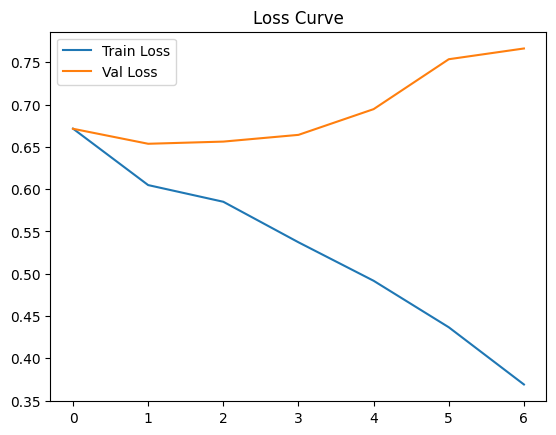

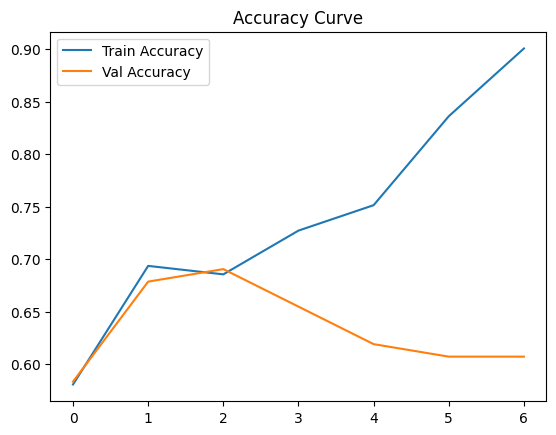

In [ ]:
import os, json, torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# === CONFIGURATION ===
FEATURE_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/features_balanced/sfft"
LABEL_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_label_balanced"
MODEL_SAVE_PATH = "best_model.pt"
SPECIES = [
    "Ae. albopictus", "C. quinquefasciatus", "An. gambiae",
    "Ae. aegypti", "An. arabiensis", "C. pipiens"
]
BATCH_SIZE, EPOCHS, LR = 16, 20, 1e-4
IMG_SIZE = (224, 224)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET ===
class SwarmMultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, species_list, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.species_list = species_list
        self.filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = Image.open(os.path.join(self.image_dir, fname)).convert("RGB")
        y = torch.zeros(len(self.species_list))
        label_path = os.path.join(self.label_dir, fname.replace(".png", ".json"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                data = json.load(f)
                for sp in data["species_count"]:
                    if sp in self.species_list:
                        y[self.species_list.index(sp)] = 1
        if self.transform:
            image = self.transform(image)
        return image, y

# === UTILS ===
def multilabel_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.mean(dim=1).mean().item()

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate(model, loader, criterion, return_preds=False):
    model.eval()
    total_loss, total_acc = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
            all_preds.append(torch.sigmoid(out).cpu())
            all_targets.append(y.cpu())
    if return_preds:
        return total_loss / len(loader.dataset), total_acc / len(loader.dataset), \
               torch.cat(all_preds), torch.cat(all_targets)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

# === MAIN TRAINING PIPELINE ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])
dataset = SwarmMultiLabelDataset(FEATURE_DIR, LABEL_DIR, SPECIES, transform=transform)

# stratified split
labels = []
for f in dataset.filenames:
    with open(os.path.join(LABEL_DIR, f.replace(".png", ".json"))) as jf:
        data = json.load(jf)
        y = [0] * len(SPECIES)
        for sp in data["species_count"]:
            if sp in SPECIES:
                y[SPECIES.index(sp)] = 1
        labels.append(y)

indices = list(range(len(dataset)))
label_sums = [sum(l) for l in labels]  # Số lượng loài trong mỗi sample

train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=label_sums)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, stratify=[label_sums[i] for i in train_idx])


train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE)

# model
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(SPECIES))
)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# training with early stopping
best_val_loss = float("inf")
patience = 5
counter = 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping.")
            break

# evaluate on test
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_acc, preds, targets = evaluate(model, test_loader, criterion, return_preds=True)
preds = (preds > 0.5).float().numpy()
targets = targets.numpy()

f1 = f1_score(targets, preds, average="macro")
precision = precision_score(targets, preds, average="macro", zero_division=0)
recall = recall_score(targets, preds, average="macro", zero_division=0)

print(f"📊 Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")
print(f"📈 F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# plot
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


Epoch 1/20 | Train Loss: 0.6697, Acc: 0.6801 | Val Loss: 0.6746, Acc: 0.6786
Epoch 2/20 | Train Loss: 0.6108, Acc: 0.6801 | Val Loss: 0.6548, Acc: 0.6786
Epoch 3/20 | Train Loss: 0.5842, Acc: 0.6801 | Val Loss: 0.6628, Acc: 0.6786
Epoch 4/20 | Train Loss: 0.5442, Acc: 0.6801 | Val Loss: 0.6890, Acc: 0.6786
Epoch 5/20 | Train Loss: 0.4876, Acc: 0.6801 | Val Loss: 0.7160, Acc: 0.6786
Epoch 6/20 | Train Loss: 0.4438, Acc: 0.6841 | Val Loss: 0.7352, Acc: 0.6786
Epoch 7/20 | Train Loss: 0.3785, Acc: 0.6976 | Val Loss: 0.7483, Acc: 0.6786
⏹️ Early stopping.
📊 Test Loss: 0.6417 | Acc: 0.6762
📈 F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000


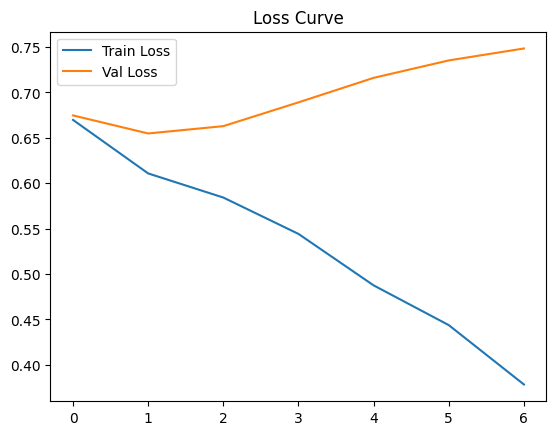

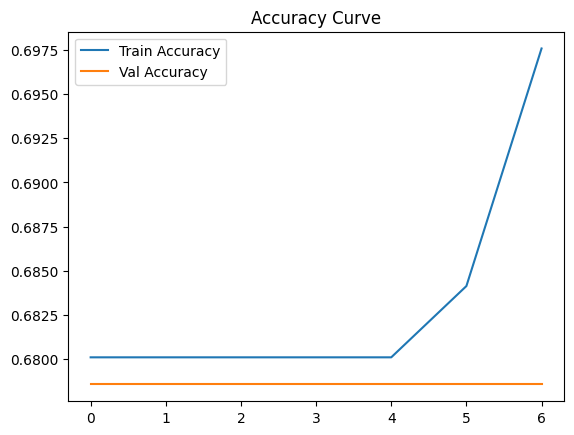

In [ ]:
import os, json, torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# === CONFIGURATION ===
FEATURE_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/features_balanced_v2/sfft"
LABEL_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_label_balanced"
MODEL_SAVE_PATH = "best_model.pt"
SPECIES = [
    "Ae. albopictus", "C. quinquefasciatus", "An. gambiae",
    "Ae. aegypti", "An. arabiensis", "C. pipiens"
]
BATCH_SIZE, EPOCHS, LR = 16, 20, 1e-4
IMG_SIZE = (224, 224)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET ===
class SwarmMultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, species_list, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.species_list = species_list
        self.filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = Image.open(os.path.join(self.image_dir, fname)).convert("RGB")
        y = torch.zeros(len(self.species_list))
        label_path = os.path.join(self.label_dir, fname.replace(".png", ".json"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                data = json.load(f)
                for sp in data["species_count"]:
                    if sp in self.species_list:
                        y[self.species_list.index(sp)] = 1
        if self.transform:
            image = self.transform(image)
        return image, y

# === UTILS ===
def multilabel_accuracy(preds, targets, threshold=0.8):
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.mean(dim=1).mean().item()

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate(model, loader, criterion, return_preds=False):
    model.eval()
    total_loss, total_acc = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
            all_preds.append(torch.sigmoid(out).cpu())
            all_targets.append(y.cpu())
    if return_preds:
        return total_loss / len(loader.dataset), total_acc / len(loader.dataset), \
               torch.cat(all_preds), torch.cat(all_targets)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

# === MAIN TRAINING PIPELINE ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])
dataset = SwarmMultiLabelDataset(FEATURE_DIR, LABEL_DIR, SPECIES, transform=transform)

# stratified split
labels = []
for f in dataset.filenames:
    with open(os.path.join(LABEL_DIR, f.replace(".png", ".json"))) as jf:
        data = json.load(jf)
        y = [0] * len(SPECIES)
        for sp in data["species_count"]:
            if sp in SPECIES:
                y[SPECIES.index(sp)] = 1
        labels.append(y)

indices = list(range(len(dataset)))
label_sums = [sum(l) for l in labels]  # Số lượng loài trong mỗi sample

train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=label_sums)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, stratify=[label_sums[i] for i in train_idx])


train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE)

# model
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(SPECIES))
)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# training with early stopping
best_val_loss = float("inf")
patience = 5
counter = 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping.")
            break

# evaluate on test
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_acc, preds, targets = evaluate(model, test_loader, criterion, return_preds=True)
preds = (preds > 0.8).float().numpy()
targets = targets.numpy()

f1 = f1_score(targets, preds, average="macro")
precision = precision_score(targets, preds, average="macro", zero_division=0)
recall = recall_score(targets, preds, average="macro", zero_division=0)

print(f"📊 Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")
print(f"📈 F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# plot
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [16]:
# Define updated path
from pathlib import Path
script_path = Path("/content/swarm_multilabel_rnn_pipeline_v2.py")

# Build updated script with testing + stratified split
script_code = """
import os
import json
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

# === CONFIGURATION ===
FEATURE_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/features_balanced_v2/sfft"
LABEL_DIR = "/content/drive/Shareddrives/[THESIS]_10421014_DTD_Shared-drive/tinyml_mosquito/datasets/Swarm_label_balanced_v2"
MODEL_SAVE_PATH = "best_rnn_model.pt"
SPECIES = ["Ae. albopictus", "C. quinquefasciatus", "An. gambiae",
           "Ae. aegypti", "An. arabiensis", "C. pipiens"]
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-4
IMG_SIZE = (224, 224)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET ===
class SwarmMultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, species_list, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.species_list = species_list
        self.filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = Image.open(os.path.join(self.image_dir, fname)).convert("RGB")
        label_path = os.path.join(self.label_dir, fname.replace(".png", ".json"))
        y = torch.zeros(len(self.species_list))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                data = json.load(f)
                for sp in data["species_count"]:
                    if sp in self.species_list:
                        y[self.species_list.index(sp)] = 1
        if self.transform:
            image = self.transform(image)
        return image, y

# === METRICS ===
def multilabel_accuracy(preds, targets, threshold=0.3):
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.mean(dim=1).mean().item()

# === MODELS ===
class CNNRNNModel(nn.Module):
    def __init__(self, base_model, rnn_type="lstm", rnn_hidden=128, output_dim=6):
        super().__init__()
        self.cnn = nn.Sequential(*list(base_model.children())[:-2])
        self.rnn_type = rnn_type
        self.rnn_input_size = base_model.fc.in_features
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(self.rnn_input_size, rnn_hidden, batch_first=True)
        else:
            self.rnn = nn.RNN(self.rnn_input_size, rnn_hidden, batch_first=True)
        self.fc = nn.Linear(rnn_hidden, output_dim)

    def forward(self, x):
        features = self.cnn(x)
        B, C, H, W = features.size()
        rnn_input = features.permute(0, 2, 3, 1).reshape(B, H * W, C)
        rnn_out, _ = self.rnn(rnn_input)
        return self.fc(rnn_out[:, -1, :])

# === TRAINING ===
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate(model, loader, criterion, return_preds=False):
    model.eval()
    total_loss, total_acc = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_acc += multilabel_accuracy(torch.sigmoid(out), y) * x.size(0)
            all_preds.append(torch.sigmoid(out).cpu())
            all_targets.append(y.cpu())
    if return_preds:
        return total_loss / len(loader.dataset), total_acc / len(loader.dataset), \
               torch.cat(all_preds), torch.cat(all_targets)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

# === MAIN ===
def main(args):
    tf = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
    ])
    dataset = SwarmMultiLabelDataset(FEATURE_DIR, LABEL_DIR, SPECIES, transform=tf)

    # stratify using label sum (approximate)
    labels = []
    for f in dataset.filenames:
        with open(os.path.join(LABEL_DIR, f.replace(".png", ".json"))) as jf:
            data = json.load(jf)
            y = [0] * len(SPECIES)
            for sp in data["species_count"]:
                if sp in SPECIES:
                    y[SPECIES.index(sp)] = 1
            labels.append(y)
    sums = [sum(l) for l in labels]
    idx = list(range(len(labels)))
    train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=sums)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, stratify=[sums[i] for i in train_idx])

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE)

    base_model = models.resnet18(weights=None)

    if args.model == "cnn":
        model = base_model
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, len(SPECIES))
        )
    else:
        model = CNNRNNModel(base_model, rnn_type=args.model, output_dim=len(SPECIES))

    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float("inf")
    patience = 5
    counter = 0
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     counter = 0
        #     torch.save(model.state_dict(), MODEL_SAVE_PATH)
        # else:
        #     counter += 1
        #     if counter >= patience:
        #         print("⏹️ Early stopping.")
        #         break

    # os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    test_loss, test_acc, preds, targets = evaluate(model, test_loader, criterion, return_preds=True)
    preds = (preds > 0.3).float().numpy()
    targets = targets.numpy()
    f1 = f1_score(targets, preds, average="macro")
    precision = precision_score(targets, preds, average="macro", zero_division=0)
    recall = recall_score(targets, preds, average="macro", zero_division=0)

    print(f"📊 Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")
    print(f"📈 F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default="cnn", choices=["cnn", "rnn", "lstm"])
    args = parser.parse_args()
    main(args)
"""

# Save updated script
script_path.write_text(script_code)
script_path

PosixPath('/content/swarm_multilabel_rnn_pipeline_v2.py')

In [ ]:
!python swarm_multilabel_rnn_pipeline_v2.py --model cnn


Epoch 1/20 | Train Loss: 0.6539, Acc: 0.3370 | Val Loss: 0.6446, Acc: 0.3269
Epoch 2/20 | Train Loss: 0.6104, Acc: 0.5118 | Val Loss: 0.6476, Acc: 0.5128
Epoch 3/20 | Train Loss: 0.5772, Acc: 0.5774 | Val Loss: 0.6770, Acc: 0.4872
Epoch 4/20 | Train Loss: 0.5192, Acc: 0.6740 | Val Loss: 0.6866, Acc: 0.4679
Epoch 5/20 | Train Loss: 0.4246, Acc: 0.7684 | Val Loss: 0.7290, Acc: 0.5064
Epoch 6/20 | Train Loss: 0.3237, Acc: 0.8783 | Val Loss: 0.7146, Acc: 0.4487
Epoch 7/20 | Train Loss: 0.2703, Acc: 0.9233 | Val Loss: 0.7909, Acc: 0.4679
Epoch 8/20 | Train Loss: 0.2204, Acc: 0.9521 | Val Loss: 0.7429, Acc: 0.5705
Epoch 9/20 | Train Loss: 0.1883, Acc: 0.9513 | Val Loss: 0.7105, Acc: 0.6282
Epoch 10/20 | Train Loss: 0.1517, Acc: 0.9742 | Val Loss: 0.7908, Acc: 0.5192
Epoch 11/20 | Train Loss: 0.1302, Acc: 0.9764 | Val Loss: 0.7775, Acc: 0.5513
Epoch 12/20 | Train Loss: 0.1240, Acc: 0.9853 | Val Loss: 0.7024, Acc: 0.5000
Epoch 13/20 | Train Loss: 0.1146, Acc: 0.9749 | Val Loss: 0.8047, Acc: 0.

In [ ]:
!python swarm_multilabel_rnn_pipeline_v2.py --model rnn


Epoch 1/20 | Train Loss: 0.6597, Acc: 0.5022 | Val Loss: 0.6603, Acc: 0.4744
Epoch 2/20 | Train Loss: 0.5333, Acc: 0.6807 | Val Loss: 0.6398, Acc: 0.5000
Epoch 3/20 | Train Loss: 0.4256, Acc: 0.8437 | Val Loss: 0.6475, Acc: 0.5064
Epoch 4/20 | Train Loss: 0.3342, Acc: 0.9130 | Val Loss: 0.6334, Acc: 0.5513
Epoch 5/20 | Train Loss: 0.2718, Acc: 0.9646 | Val Loss: 0.6822, Acc: 0.4744
Epoch 6/20 | Train Loss: 0.2256, Acc: 0.9882 | Val Loss: 0.6926, Acc: 0.4679
Epoch 7/20 | Train Loss: 0.1994, Acc: 0.9912 | Val Loss: 0.7170, Acc: 0.4744
Epoch 8/20 | Train Loss: 0.1722, Acc: 0.9971 | Val Loss: 0.7105, Acc: 0.4359
Epoch 9/20 | Train Loss: 0.1542, Acc: 1.0000 | Val Loss: 0.7200, Acc: 0.5064
Epoch 10/20 | Train Loss: 0.1406, Acc: 1.0000 | Val Loss: 0.7349, Acc: 0.4808
Epoch 11/20 | Train Loss: 0.1306, Acc: 0.9993 | Val Loss: 0.7217, Acc: 0.5192
Epoch 12/20 | Train Loss: 0.1246, Acc: 1.0000 | Val Loss: 0.7345, Acc: 0.5192
Epoch 13/20 | Train Loss: 0.1199, Acc: 1.0000 | Val Loss: 0.7787, Acc: 0.

In [17]:
!python swarm_multilabel_rnn_pipeline_v2.py --model lstm

Epoch 1/20 | Train Loss: 0.6530, Acc: 0.3341 | Val Loss: 0.6413, Acc: 0.3269
Epoch 2/20 | Train Loss: 0.5844, Acc: 0.5206 | Val Loss: 0.6402, Acc: 0.3077
Epoch 3/20 | Train Loss: 0.5131, Acc: 0.6586 | Val Loss: 0.6313, Acc: 0.4038
Epoch 4/20 | Train Loss: 0.4371, Acc: 0.8245 | Val Loss: 0.6068, Acc: 0.5256
Epoch 5/20 | Train Loss: 0.3660, Acc: 0.8879 | Val Loss: 0.6089, Acc: 0.5641
Epoch 6/20 | Train Loss: 0.3067, Acc: 0.9476 | Val Loss: 0.6192, Acc: 0.5385
Epoch 7/20 | Train Loss: 0.2596, Acc: 0.9698 | Val Loss: 0.6582, Acc: 0.5577
Epoch 8/20 | Train Loss: 0.2229, Acc: 0.9845 | Val Loss: 0.6284, Acc: 0.6026
Epoch 9/20 | Train Loss: 0.1999, Acc: 0.9978 | Val Loss: 0.6544, Acc: 0.6090
Epoch 10/20 | Train Loss: 0.1784, Acc: 0.9963 | Val Loss: 0.6407, Acc: 0.6090
Epoch 11/20 | Train Loss: 0.1672, Acc: 0.9934 | Val Loss: 0.6603, Acc: 0.5897
Epoch 12/20 | Train Loss: 0.1718, Acc: 0.9867 | Val Loss: 0.6139, Acc: 0.6154
Epoch 13/20 | Train Loss: 0.1577, Acc: 0.9963 | Val Loss: 0.6749, Acc: 0.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python swarm_multilabel_rnn_pipeline_v2.py --model lstm

Epoch 1/20 | Train Loss: 0.6500, Acc: 0.6512 | Val Loss: 0.6411, Acc: 0.6731
Epoch 2/20 | Train Loss: 0.5875, Acc: 0.6704 | Val Loss: 0.6413, Acc: 0.6731
Epoch 3/20 | Train Loss: 0.5259, Acc: 0.6895 | Val Loss: 0.6348, Acc: 0.6731
Epoch 4/20 | Train Loss: 0.4536, Acc: 0.8223 | Val Loss: 0.6259, Acc: 0.6410
Epoch 5/20 | Train Loss: 0.3795, Acc: 0.9159 | Val Loss: 0.6246, Acc: 0.6603
Epoch 6/20 | Train Loss: 0.3149, Acc: 0.9845 | Val Loss: 0.6260, Acc: 0.6538
Epoch 7/20 | Train Loss: 0.2890, Acc: 0.9801 | Val Loss: 0.6379, Acc: 0.6603
Epoch 8/20 | Train Loss: 0.2390, Acc: 1.0000 | Val Loss: 0.6387, Acc: 0.6667
Epoch 9/20 | Train Loss: 0.2075, Acc: 1.0000 | Val Loss: 0.6135, Acc: 0.6603
Epoch 10/20 | Train Loss: 0.1831, Acc: 0.9993 | Val Loss: 0.6569, Acc: 0.6218
Epoch 11/20 | Train Loss: 0.1882, Acc: 1.0000 | Val Loss: 0.6778, Acc: 0.6410
Epoch 12/20 | Train Loss: 0.1814, Acc: 0.9993 | Val Loss: 0.6924, Acc: 0.6282
Epoch 13/20 | Train Loss: 0.1539, Acc: 0.9993 | Val Loss: 0.6628, Acc: 0.

In [23]:
# Complete standalone inference cell

# --- Imports ---
import soundfile as sf
import librosa
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models

# --- Configuration ---
TARGET_SR   = 16000
METHOD      = "sfft"                 # choose "sfft" or "cwt"
IMG_SIZE    = (224, 224)
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SPECIES     = ["Ae. albopictus", "C. quinquefasciatus", "An. gambiae",
               "Ae. aegypti", "An. arabiensis", "C. pipiens"]
MODEL_PATH  = "best_rnn_model.pt"    # ensure this file is in your current directory
THRESHOLD   = 0.3

# --- Utility functions ---
def make_sfft_image(y, sr, out_path):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    db  = librosa.power_to_db(mel, ref=np.max)
    plt.figure(figsize=(2.24,2.24), dpi=100)
    plt.axis('off')
    librosa.display.specshow(db, sr=sr, x_axis=None, y_axis=None)
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def make_cwt_image(y, sr, out_path):
    scales = np.arange(1, 128)
    coeffs, _ = pywt.cwt(y, scales, 'morl', sampling_period=1/sr)
    abs_cwt   = np.abs(coeffs)
    plt.figure(figsize=(2.24,2.24), dpi=100)
    plt.axis('off')
    plt.imshow(abs_cwt, extent=[0, len(y)/sr, 1, 128], aspect='auto')
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# --- Model definition ---
class CNNRNNModel(nn.Module):
    def __init__(self, base_model, rnn_hidden=128, output_dim=6):
        super().__init__()
        self.cnn = nn.Sequential(*list(base_model.children())[:-2])
        self.rnn_input_size = base_model.fc.in_features
        self.rnn = nn.LSTM(self.rnn_input_size, rnn_hidden, batch_first=True)
        self.fc  = nn.Linear(rnn_hidden, output_dim)
    def forward(self, x):
        feat = self.cnn(x)
        B,C,H,W = feat.size()
        rnn_in  = feat.permute(0,2,3,1).reshape(B, H*W, C)
        out, _ = self.rnn(rnn_in)
        return self.fc(out[:, -1, :])

# --- Inference function ---
def infer_from_audio(audio_path):
    # Load audio
    y, sr = sf.read(audio_path)
    if sr != TARGET_SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
    # Create temporary image
    tmp_img = "tmp_input.png"
    if METHOD == "sfft":
        make_sfft_image(y, TARGET_SR, tmp_img)
    else:
        make_cwt_image(y, TARGET_SR, tmp_img)
    # Preprocess image
    tf = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])
    img = Image.open(tmp_img).convert("RGB")
    x   = tf(img).unsqueeze(0).to(DEVICE)
    # Build and load model
    base  = models.resnet18(weights=None)
    model = CNNRNNModel(base, rnn_hidden=128, output_dim=len(SPECIES))
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE).eval()
    # Predict
    with torch.no_grad():
        logits = model(x)
        probs  = torch.sigmoid(logits).cpu().numpy().squeeze()
    # Display results
    print(f"\nInference on: {audio_path}")
    for i,p in enumerate(probs):
        mark = "✓" if p>THRESHOLD else "✗"
        print(f"  {SPECIES[i]:25s}: {p:.3f} {mark}")

# === Run inference ===
# Replace 'your_audio.wav' with your .wav path and ensure MODEL_PATH is correct
audio_file = '/content/record.wav'
infer_from_audio(audio_file)



Inference on: /content/record.wav
  Ae. albopictus           : 0.499 ✓
  C. quinquefasciatus      : 0.162 ✗
  An. gambiae              : 0.038 ✗
  Ae. aegypti              : 0.842 ✓
  An. arabiensis           : 0.374 ✓
  C. pipiens               : 0.071 ✗


In [26]:
infer_from_audio('/content/record.wav')
infer_from_audio('/content/record_2.wav')
infer_from_audio('/content/record_3.wav')
infer_from_audio('/content/record_5.wav')
infer_from_audio('/content/record_6.wav')
infer_from_audio('/content/record_7.wav')
infer_from_audio('/content/record_8.wav')
infer_from_audio('/content/record_9.wav')
infer_from_audio('/content/record_11.wav')
infer_from_audio('/content/record_12.wav')
infer_from_audio('/content/record_13.wav')
infer_from_audio('/content/record_14.wav')


Inference on: /content/record.wav
  Ae. albopictus           : 0.499 ✓
  C. quinquefasciatus      : 0.162 ✗
  An. gambiae              : 0.038 ✗
  Ae. aegypti              : 0.842 ✓
  An. arabiensis           : 0.374 ✓
  C. pipiens               : 0.071 ✗

Inference on: /content/record_2.wav
  Ae. albopictus           : 0.635 ✓
  C. quinquefasciatus      : 0.137 ✗
  An. gambiae              : 0.205 ✗
  Ae. aegypti              : 0.111 ✗
  An. arabiensis           : 0.145 ✗
  C. pipiens               : 0.086 ✗

Inference on: /content/record_3.wav
  Ae. albopictus           : 0.524 ✓
  C. quinquefasciatus      : 0.099 ✗
  An. gambiae              : 0.187 ✗
  Ae. aegypti              : 0.512 ✓
  An. arabiensis           : 0.391 ✓
  C. pipiens               : 0.019 ✗

Inference on: /content/record_5.wav
  Ae. albopictus           : 0.444 ✓
  C. quinquefasciatus      : 0.110 ✗
  An. gambiae              : 0.056 ✗
  Ae. aegypti              : 0.353 ✓
  An. arabiensis           : 0.475 ✓
  C

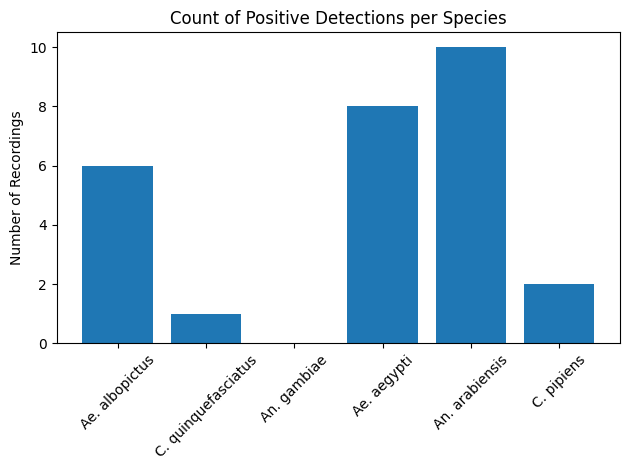

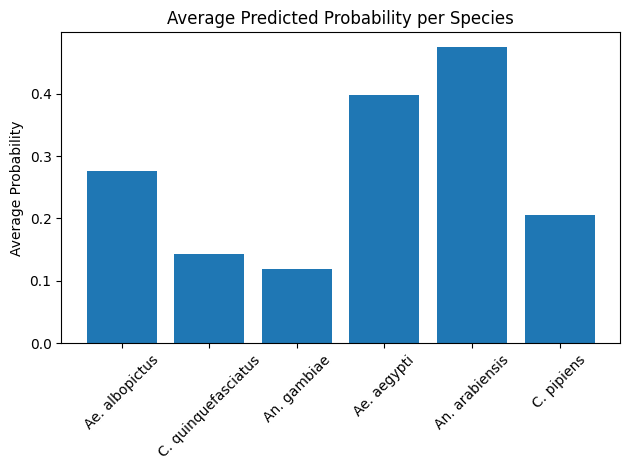

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from ace_tools import display_dataframe_to_user

# Inference results
records = [
    'record.wav', 'record_2.wav', 'record_3.wav', 'record_5.wav',
    'record_6.wav', 'record_7.wav', 'record_8.wav', 'record_9.wav',
    'record_11.wav', 'record_12.wav', 'record_13.wav', 'record_14.wav'
]
probs = [
    [0.499, 0.162, 0.038, 0.842, 0.374, 0.071],
    [0.635, 0.137, 0.205, 0.111, 0.145, 0.086],
    [0.524, 0.099, 0.187, 0.512, 0.391, 0.019],
    [0.444, 0.110, 0.056, 0.353, 0.475, 0.166],
    [0.346, 0.081, 0.107, 0.531, 0.687, 0.091],
    [0.230, 0.131, 0.088, 0.498, 0.259, 0.296],
    [0.074, 0.414, 0.205, 0.309, 0.363, 0.350],
    [0.047, 0.160, 0.036, 0.237, 0.856, 0.282],
    [0.042, 0.124, 0.189, 0.560, 0.513, 0.089],
    [0.020, 0.117, 0.185, 0.417, 0.586, 0.438],
    [0.135, 0.149, 0.069, 0.273, 0.490, 0.286],
    [0.317, 0.028, 0.065, 0.133, 0.553, 0.284],
]
species = ["Ae. albopictus", "C. quinquefasciatus", "An. gambiae",
           "Ae. aegypti", "An. arabiensis", "C. pipiens"]
threshold = 0.3

# Build DataFrame for probabilities and predictions
df_probs = pd.DataFrame(probs, index=records, columns=species)
df_preds = df_probs > threshold
df = df_probs.copy()
for sp in species:
    df[f"{sp} (pred)"] = df_preds[sp]

# # Display detailed table
# display_dataframe_to_user("Inference Results (Probabilities & Predictions)", df)

# Summary metrics
count_preds = df_preds.sum(axis=0)
avg_probs = df_probs.mean(axis=0)

# Plot count of positive detections per species
plt.figure()
plt.bar(species, count_preds)
plt.title("Count of Positive Detections per Species")
plt.ylabel("Number of Recordings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot average predicted probability per species
plt.figure()
plt.bar(species, avg_probs)
plt.title("Average Predicted Probability per Species")
plt.ylabel("Average Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()